##Implementation of Chrononet CNN-RNN(keras):https://arxiv.org/abs/1802.00308 deep learning

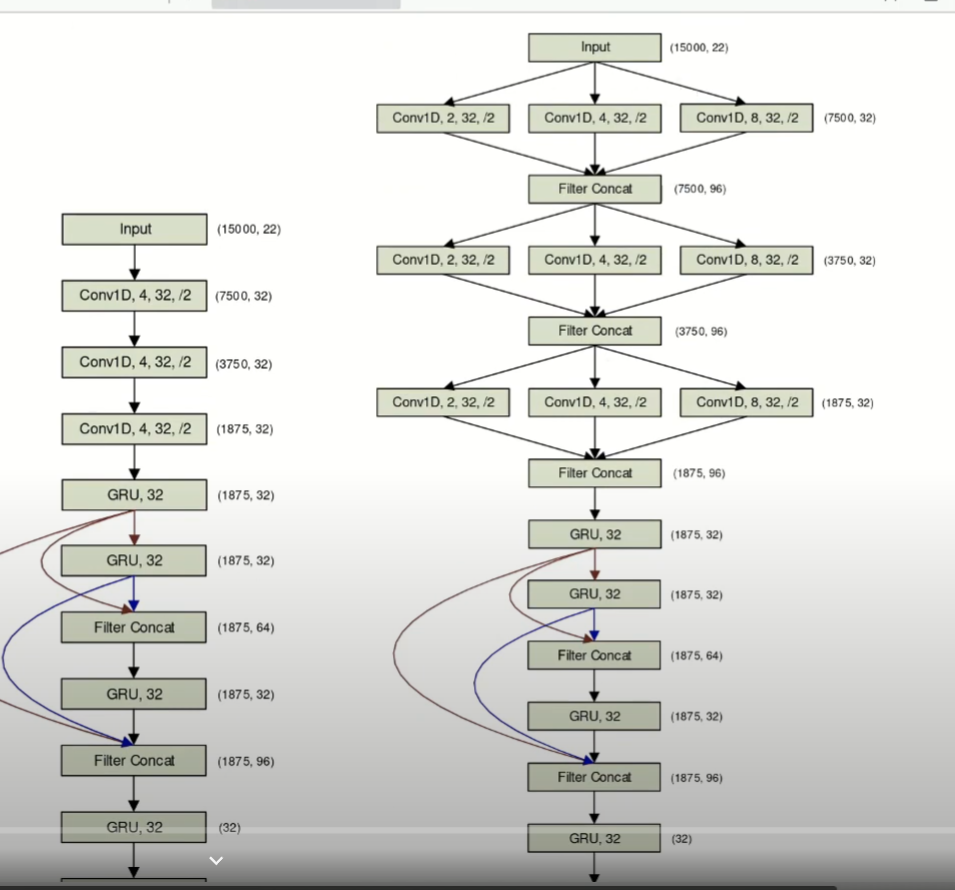


In [1]:
from glob import glob
import scipy.io
import torch.nn as nn
import torch
import numpy as np
import mne
from features import concatenate_features

C:\Users\786me\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# input=torch.randn(3,22,15000)
# input.shape

In [3]:
def read_data(file_path):
    data= mne.io.read_raw_edf(file_path,preload=True)
    data.set_eeg_reference() #sets refrence as average
    data.filter(l_freq=0.5,h_freq=50)#basic filter to the data again
    #split data into segments
    epochs=mne.make_fixed_length_epochs(data,duration=4, overlap=1)
    data=epochs.get_data() # converts data from mne object to numpy array
    return data

In [4]:
%%capture
all_fp=glob('all_PD_edf/*.edf') #the path of all files is in all_fp

healthy_fp= [ i for i in all_fp if 'h' in i.split('\\')[1]] #List of path of all healthy subjects
patient_fp= [ i for i in all_fp if 'p' in i.split('\\')[1]]#List path of all sick subjects

healthy_epochs_list=[read_data(i) for i in healthy_fp] # (no of healthy subjects) * (No.of epochs/trials, channels, length of signal)
patient_epochs_list=[read_data(i) for i in patient_fp] # # (no of Sick subjects) * (No.of epochs/trials, channels, length of signal)

healthy_epochs_array_lable= [[0]*len(i) for i in healthy_epochs_list ]
patient_epochs_array_lable= [[1]*len(i) for i in patient_epochs_list ]

In [5]:
data_list=healthy_epochs_list+patient_epochs_list
label_list= healthy_epochs_array_lable+ patient_epochs_array_lable
groups_list=[[i]*len(j) for i, j in enumerate(data_list)]
print(len(data_list),len(label_list),len(groups_list))

26 26 26


In [6]:
import numpy as np
data_array=np.concatenate(data_list)
label_array=np.concatenate(label_list)
group_array=np.concatenate(groups_list)
data_array=np.moveaxis(data_array,1,2)

print(data_array.shape,label_array.shape,group_array.shape)

(1684, 2048, 33) (1684,) (1684,)


In [39]:
from sklearn.model_selection import GroupKFold,LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler
gkf=GroupKFold()
from sklearn.base import TransformerMixin,BaseEstimator
from sklearn.preprocessing import StandardScaler
#https://stackoverflow.com/questions/50125844/how-to-standard-scale-a-3d-matrix
class StandardScaler3D(BaseEstimator,TransformerMixin):
    #batch, sequence, channels
    def __init__(self):
        self.scaler = StandardScaler()

    def fit(self,X,y=None):
        self.scaler.fit(X.reshape(-1, X.shape[2]))
        return self

    def transform(self,X):
        return self.scaler.transform(X.reshape( -1,X.shape[2])).reshape(X.shape)

In [40]:
X=data_array
y=label_array
groups=group_array

In [45]:
accuracy=[]
for train_index, val_index in gkf.split(data_array, label_array, groups=group_array):
    train_features,train_labels=data_array[train_index],label_array[train_index]
    val_features,val_labels=data_array[val_index],label_array[val_index]
    scaler=StandardScaler3D()
    train_features=scaler.fit_transform(train_features)
    val_features=scaler.transform(val_features)
    train_features=np.moveaxis(train_features,1,2)
    val_features=np.moveaxis(val_features,1,2)

    break
    
lul=train_features.shape    

(1337, 2048, 33)


In [48]:
train_features = torch.Tensor(train_features)
val_features = torch.Tensor(val_features)
train_labels = torch.Tensor(train_labels)
val_labels = torch.Tensor(val_labels)

In [49]:
len(val_features),len(val_labels)

(347, 347)

In [50]:

print(lul)
train_features.shape

(1337, 33, 2048)


torch.Size([1337, 33, 2048])

In [57]:
class Block(nn.Module):
  def __init__(self,inplace):
    super().__init__()
    self.conv1=nn.Conv1d(in_channels=inplace,out_channels=32,kernel_size=2,stride=2,padding=0)
    self.conv2=nn.Conv1d(in_channels=inplace,out_channels=32,kernel_size=4,stride=2,padding=1)
    self.conv3=nn.Conv1d(in_channels=inplace,out_channels=32,kernel_size=8,stride=2,padding=3)
    self.relu=nn.ReLU()

  def forward(self,x):
    x1=self.relu(self.conv1(x))
    x2=self.relu(self.conv2(x))
    x3=self.relu(self.conv3(x))
    x=torch.cat([x1,x3,x3],dim=1)
    return x

In [65]:
class ChronoNet(nn.Module):
  def __init__(self,channel):
    super().__init__()
    self.block1=Block(channel)
    self.block2=Block(96)
    self.block3=Block(96)
    self.gru1=nn.GRU(input_size=96,hidden_size=32,batch_first=True)
    self.gru2=nn.GRU(input_size=32,hidden_size=32,batch_first=True)
    self.gru3=nn.GRU(input_size=64,hidden_size=32,batch_first=True)
    self.gru4=nn.GRU(input_size=96,hidden_size=32,batch_first=True)
    self.gru_linear=nn.Linear(256,1)#<<<-----
    self.flatten=nn.Flatten()
    self.fc1=nn.Linear(32,1)
    self.relu=nn.ReLU()
  def forward(self,x):
    x=self.block1(x)
    x=self.block2(x)
    x=self.block3(x)
    x=x.permute(0,2,1)
    gru_out1,_=self.gru1(x)
    gru_out2,_=self.gru2(gru_out1)
    gru_out=torch.cat([gru_out1,gru_out2],dim=2)
    gru_out3,_=self.gru3(gru_out)
    gru_out=torch.cat([gru_out1,gru_out2,gru_out3],dim=2)
    print('gru_out',gru_out.shape)
    x=gru_out.shape
    print(x[1])
    linear_out=self.relu(self.gru_linear(gru_out.permute(0,2,1)))
    gru_out4,_=self.gru4(linear_out.permute(0,2,1))
    x=self.flatten(gru_out4)
    x=self.fc1(x)
    return x

In [66]:
input=torch.randn(3,lul[1],lul[2])
input.shape
model=ChronoNet(lul[1])
out=model(input)
out.shape

gru_out torch.Size([3, 256, 96])
256


torch.Size([3, 1])

In [67]:
from pytorch_lightning import LightningModule,Trainer
import torchmetrics
from torch.utils.data import TensorDataset,DataLoader

In [72]:
class ChronoModel(LightningModule):
  def __init__(self):
    super(ChronoModel,self).__init__()
    self.model=ChronoNet(lul[1])
    self.lr=1e-3
    self.bs=12
    self.worker=2
    self.acc=torchmetrics.Accuracy()
    self.creterion=nn.BCEWithLogitsLoss()

  def forward(self,x):
    x=self.model(x)
    return x

  def configure_optimizers(self):
    return torch.optim.Adam(self.parameters(),lr=self.lr)

  def train_dataloader(self):
    dataset=TensorDataset(train_features,train_labels)
    dataloader=DataLoader(dataset,batch_size=self.bs,num_workers=self.worker,shuffle=True)
    return dataloader

  def training_step(self,batch,batch_idx):
    signal,label=batch
    out=self(signal.float())
    loss=self.creterion(out.flatten(),label.float().flatten())
    acc=self.acc(out.flatten(),label.long().flatten())
    return {'loss':loss,'acc':acc}

  def trained_epoch_end(self,outputs):
    acc=torch.stack([x['acc'] for x in outputs]).mean().detach().cpu().numpy().round(2)
    loss=torch.stack([x['loss'] for x in outputs]).mean().detach().cpu().numpy().round(2)
    print('train acc loss',acc,loss)

  def val_dataloader(self):
    dataset=TensorDataset(val_features,val_labels)
    dataloader=DataLoader(dataset,batch_size=self.bs,num_workers=self.worker,shuffle=True)
    return dataloader

  def validation_step(self,batch,batch_idx):
    signal,label=batch
    out=self(signal.float())
    loss=self.creterion(out.flatten(),label.float().flatten())
    acc=self.acc(out.flatten(),label.long().flatten())
    return {'loss':loss,'acc':acc}

  def validation_epoch_end(self,outputs):
    acc=torch.stack([x['acc'] for x in outputs]).mean().detach().cpu().numpy().round(2)
    loss=torch.stack([x['loss'] for x in outputs]).mean().detach().cpu().numpy().round(2)
    print('val acc loss',acc,loss)

In [25]:
model=ChronoModel()

In [26]:
trainer=Trainer(max_epochs=5)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [75]:
trainer.fit(model)

Missing logger folder: C:\Users\786me\Desktop\Summer Internship\lightning_logs

  | Name      | Type              | Params
------------------------------------------------
0 | model     | ChronoNet         | 142 K 
1 | acc       | Accuracy          | 0     
2 | creterion | BCEWithLogitsLoss | 0     
------------------------------------------------
142 K     Trainable params
0         Non-trainable params
142 K     Total params
0.568     Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|                                                              | 0/2 [00:00<?, ?it/s]gru_out torch.Size([12, 256, 96])
256
Sanity Checking DataLoader 0:  50%|███████████████████████████                           | 1/2 [00:00<00:00, 10.82it/s]gru_out torch.Size([12, 256, 96])
256
Sanity Checking DataLoader 0: 100%|██████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.15it/s]val acc loss 0.29 0.66
                                                                                                                       

C:\Users\786me\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:219: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0:   0%|                                                                                 | 0/141 [00:00<?, ?it/s]gru_out torch.Size([12, 256, 96])
256
Epoch 0:   1%|▎                                                   | 1/141 [00:01<02:29,  1.07s/it, loss=0.696, v_num=0]gru_out torch.Size([12, 256, 96])
256
Epoch 0:   1%|▋                                                   | 2/141 [00:01<01:30,  1.53it/s, loss=0.696, v_num=0]gru_out torch.Size([12, 256, 96])
256
Epoch 0:   2%|█                                                   | 3/141 [00:01<01:11,  1.92it/s, loss=0.692, v_num=0]gru_out torch.Size([12, 256, 96])
256
Epoch 0:   3%|█▍                                                  | 4/141 [00:01<01:02,  2.21it/s, loss=0.693, v_num=0]gru_out torch.Size([12, 256, 96])
256
Epoch 0:   4%|█▊                                                  | 5/141 [00:02<00:55,  2.44it/s, loss=0.695, v_num=0]gru_out torch.Size([12, 256, 96])
256
Epoch 0:   4%|██▏                                         

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████████████████████████████████████████████| 141/141 [00:32<00:00,  4.40it/s, loss=0.695, v_num=0]


In [83]:
dir(trainer)

['_Trainer__init_profiler',
 '_Trainer__set_ckpt_path',
 '_Trainer__setup_profiler',
 '__abstractmethods__',
 '__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_accelerator_connector',
 '_active_loop',
 '_call_and_handle_interrupt',
 '_call_callback_hooks',
 '_call_callbacks_load_state_dict',
 '_call_callbacks_on_load_checkpoint',
 '_call_callbacks_on_save_checkpoint',
 '_call_callbacks_state_dict',
 '_call_configure_sharded_model',
 '_call_lightning_datamodule_hook',
 '_call_lightning_module_hook',
 '_call_setup_hook',
 '_call_strategy_hook',
 '_call_teardown_hook',
 '_callback_connector',
 '_checkpoint_connector',
 '_ckpt

In [87]:
trainer.precision

32

In [30]:
%%capture
TS_epochs_list = read_data('all_PD_edf/pd22off.edf')
TS_epochs_array=np.array(TS_epochs_list)

In [31]:
TS_epochs_array=np.moveaxis(TS_epochs_array, 1, 2)
print(TS_epochs_array.shape)

(62, 2048, 33)
